# Load modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
sys.path.append("../src/")

from lbd_functions import printtimelogwithstarline,printtimelog
from utils import get_ecdf_area_difference, get_ecdf, interpolate_ecdf, interp_ecdf_normalize_x
from utils import get_spherical_coordinate_from_proportions, get_proportions_from_spherical_coordinates
from utils import get_best_fitting_plane,get_Z_from_plane_coeffs,remove_trend_from_data

import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python

# df_summary = pd.read_csv('../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv')
# df_classified_log_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_classified.csv'
df_summary = pd.read_csv('../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_summary.csv')
df_classified_log_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_classified.csv'

output_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_classified_semi_vario_pct.npz'

def get_df_2D_prop(df_2D_proportions_level_0,level_0_name,df_summary):
    ix_2D_prop = np.asarray(np.where(df_2D_proportions_level_0['level_0']==level_0_name)).flatten()
    df_2D_prop = df_summary[['RN','Easting','Northing']].copy()
    df_2D_prop = df_summary[['RN','Easting','Northing']].join(df_2D_proportions_level_0.loc[ix_2D_prop,['RN','proportion']].set_index('RN'),on='RN',how='outer')
    ixtmp = np.asarray(np.where(df_2D_prop['proportion'].isnull())).flatten()
    df_2D_prop.loc[ixtmp,'proportion']=0.0
    return df_2D_prop 

def add_nst_cols(df_2D_prop, colname, plot=False):
    # NORMAL SCORE TRANSFORM
    df_2D_prop['tv_'+colname] = np.nan
    df_2D_prop['tns_'+colname] = np.nan
    df_2D_prop['nst_'+colname] = np.nan
    df_2D_prop.loc[:,'nst_'+colname], df_2D_prop.loc[:,'tv_'+colname], df_2D_prop.loc[:,'tns_'+colname] = geostats.nscore(df_2D_prop, colname)
    if plot:
        # check plot
        plt.figure(dpi=100)
        plt.hist(df_2D_prop.loc[:,'nst_'+colname], bins=20)
        plt.title('histrogram of Normal Score Transformed '+colname)
        plt.show()
    return

def get_varmap(df_2D_prop,colname,lag_nb,lag_width):
    vmap, _ = geostats.varmapv(df_2D_prop,'Easting','Northing',colname,tmin=-999,tmax=999,nxlag=lag_nb,nylag=lag_nb,dxlag=lag_width,dylag=lag_width,minnp=1,isill=1)
    nanidx_sand = np.where(vmap==-999)
    vmap[nanidx_sand]=np.nan
    return vmap


In [2]:
df_processed_log = pd.read_csv(df_classified_log_fn)

ix_sediments = np.asarray(np.where(
    (df_processed_log['level_0']!='Basement') & 
    (df_processed_log['level_0']!='Weathered basement')
)).flatten()


### Proportion estimation

In [3]:
# 2D proportions - prop average by drillhole
df_2D_proportions_level_0 = df_processed_log.loc[ix_sediments,['RN','level_0','thickness']].groupby(['RN','level_0'],as_index=False).sum()
df_bh_thickness = df_2D_proportions_level_0.groupby(['RN'],as_index=False).sum() #.rename(columns = {'thickness': 'bh_thickness'})
df_2D_proportions_level_0 = df_2D_proportions_level_0.join(df_bh_thickness.set_index('RN'),on='RN', how='left', lsuffix='',rsuffix='_bh')
df_2D_proportions_level_0['proportion'] = df_2D_proportions_level_0['thickness']/df_2D_proportions_level_0['thickness_bh']

# TO GET ONE ROW PER BOREHOLE, EVEN IF PROPORTION==0
df_2D_prop_clay = get_df_2D_prop(df_2D_proportions_level_0,'Clay',df_summary)
df_2D_prop_sand = get_df_2D_prop(df_2D_proportions_level_0,'Sands',df_summary)
df_2D_prop_inte = get_df_2D_prop(df_2D_proportions_level_0,'Intermediate',df_summary)

df_2D_prop_clay.rename(columns={'proportion': 'prop_clay'},inplace=True)
df_2D_prop_sand.rename(columns={'proportion': 'prop_sand'},inplace=True)
df_2D_prop_inte.rename(columns={'proportion': 'prop_inte'},inplace=True)

df_2D_prop = df_2D_prop_clay.join(df_2D_prop_sand[['RN','prop_sand']].set_index('RN'),on='RN', how='left').join(
    df_2D_prop_inte[['RN','prop_inte']].set_index('RN'),on='RN', how='left')

# We do the following to indentify incomplete data only (not the most direct way, but it works)
df_2D_prop['theta'],df_2D_prop['phi'] = get_spherical_coordinate_from_proportions(df_2D_prop['prop_clay'].values,
                                                                                  df_2D_prop['prop_sand'].values,
                                                                                  df_2D_prop['prop_inte'].values)

ix = np.asarray(np.where(df_2D_prop['phi'].isnull() | df_2D_prop['theta'].isnull())).flatten()
#df_2D_prop.iloc[ix,:]
df_2D_prop.drop(ix,inplace=True)
df_2D_prop.reset_index(drop=True,inplace=True)

df_2D_prop.to_csv('../data/boreholes-processed/spatial-proportions-corrected.csv')


C:\Users\00102908\my-UWA\LBD-facies-modeling\notebooks\../src\utils.py:176: RuntimeWarning: invalid value encountered in divide
  x = np.sqrt(p1/psum)
C:\Users\00102908\my-UWA\LBD-facies-modeling\notebooks\../src\utils.py:177: RuntimeWarning: invalid value encountered in divide
  y = np.sqrt(p2/psum)
C:\Users\00102908\my-UWA\LBD-facies-modeling\notebooks\../src\utils.py:178: RuntimeWarning: invalid value encountered in divide
  z = np.sqrt(p3/psum)


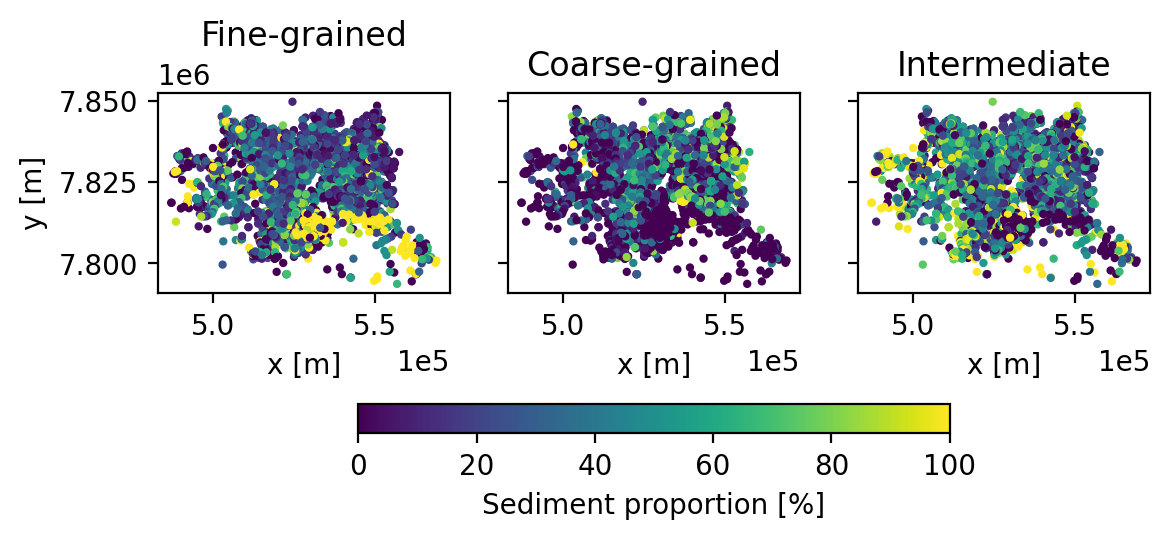

In [4]:
df_2D_prop = pd.read_csv('../data/boreholes-processed/spatial-proportions-corrected.csv')

scilim_x = 5
scilim_y = 6

aspectr = 1.0

s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('Fine-grained')
im0=ax[0].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_clay'].values*1E2,
                  cmap='viridis',s=s)
ax[0].set_aspect(aspectr)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
# fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Coarse-grained')
im1=ax[1].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_sand'].values*1E2,
                  cmap='viridis',s=s)
ax[1].set_aspect(aspectr)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[1].set_xlabel('x [m]')
# ax[1].set_ylabel('y [m]')
# fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate')
im2=ax[2].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_inte'].values*1E2,
                  cmap='viridis',s=s)
ax[2].set_aspect(aspectr)
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[2].set_xlabel('x [m]')
# ax[2].set_ylabel('y [m]')
# fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

#fig.suptitle('Spatial distribution of sediment proportions')
fig.colorbar(im0,ax=ax, orientation='horizontal', fraction=.04,label='Sediment proportion [%]') #images[0], 
plt.show()

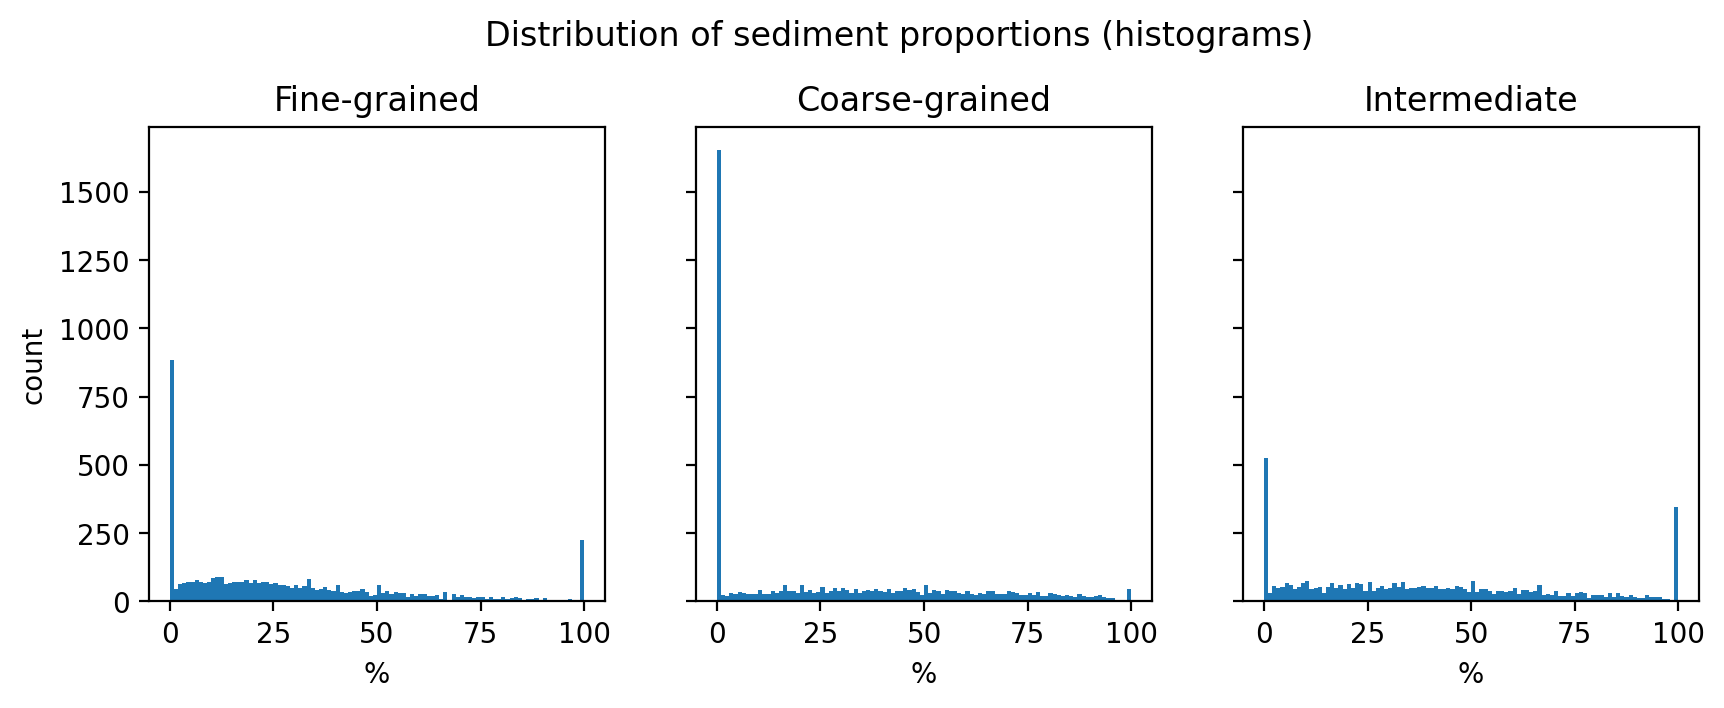

In [5]:
nbins=100
fig,ax = plt.subplots(1,3,dpi=200,sharey=True,figsize=(10,3))
plt.suptitle('Distribution of sediment proportions (histograms)')
ax[0].set_title('Fine-grained')
ax[0].hist(100*df_2D_prop['prop_clay'].values,nbins)
ax[0].set_ylabel('count')
ax[0].set_xlabel('%')
ax[1].set_title('Coarse-grained')
ax[1].hist(100*df_2D_prop['prop_sand'].values,nbins)
ax[1].set_xlabel('%')
ax[2].set_title('Intermediate')
ax[2].hist(100*df_2D_prop['prop_inte'].values,nbins)
ax[2].set_xlabel('%')
plt.subplots_adjust(top=0.8,bottom=0.01)
plt.show()

### Semi-variogram analysis

In [6]:
# FIND PLANAR TREND
xmin = 52.5*1E4
xmax = 56*1E4
ymin= 781*1E4
ymax = 785*1E4

dx = dy = 250
nx = np.round((xmax-xmin)/dx).astype(int)
ny = np.round((ymax-ymin)/dy).astype(int)

xvec = np.linspace(xmin+dx/2,xmax-dx/2,num=nx,endpoint=True)
yvec = np.linspace(ymin+dy/2,ymax-dy/2,num=ny,endpoint=True)
X,Y = np.meshgrid(xvec,yvec)

plane_coeffs_clay_prop = get_best_fitting_plane(df_2D_prop,'prop_clay')
trend_clay_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_clay_prop)
df_2D_prop['clay_dtd'] = remove_trend_from_data(df_2D_prop,'prop_clay',plane_coeffs_clay_prop)

plane_coeffs_sand_prop = get_best_fitting_plane(df_2D_prop,'prop_sand')
trend_sand_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_sand_prop)
df_2D_prop['sand_dtd'] = remove_trend_from_data(df_2D_prop,'prop_sand',plane_coeffs_sand_prop)

plane_coeffs_inte_prop = get_best_fitting_plane(df_2D_prop,'prop_inte')
trend_inte_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_inte_prop)
df_2D_prop['inte_dtd'] = remove_trend_from_data(df_2D_prop,'prop_inte',plane_coeffs_inte_prop)


trend_min = np.min([trend_clay_prop.min(),trend_sand_prop.min(),trend_inte_prop.min()])
trend_max = np.max([trend_clay_prop.max(),trend_sand_prop.max(),trend_inte_prop.max()])

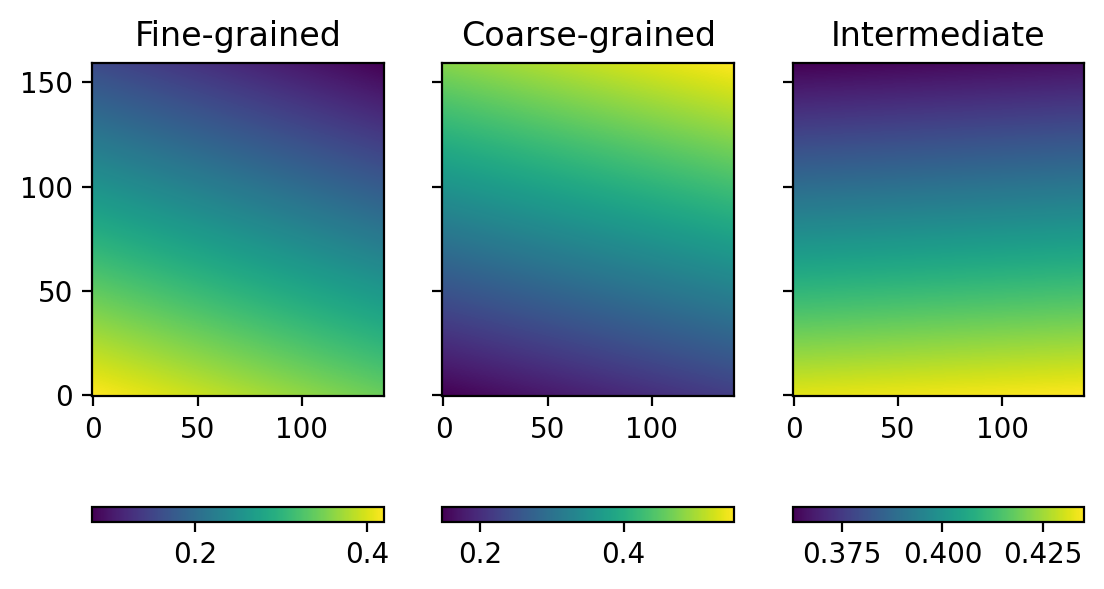

In [7]:
# PLOT PLANAR TREND
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
# plt.suptitle('Trend of sediment proportions (best fitting plane)')
ax[0].set_title('Fine-grained')
im0=ax[0].imshow(trend_clay_prop, origin='lower', cmap='viridis')
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Coarse-grained')
im1=ax[1].imshow(trend_sand_prop, origin='lower', cmap='viridis')
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate')
im2=ax[2].imshow(trend_inte_prop, origin='lower', cmap='viridis')
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

# fig.subplots_adjust(top=1.8,bottom=0.5)
plt.show()

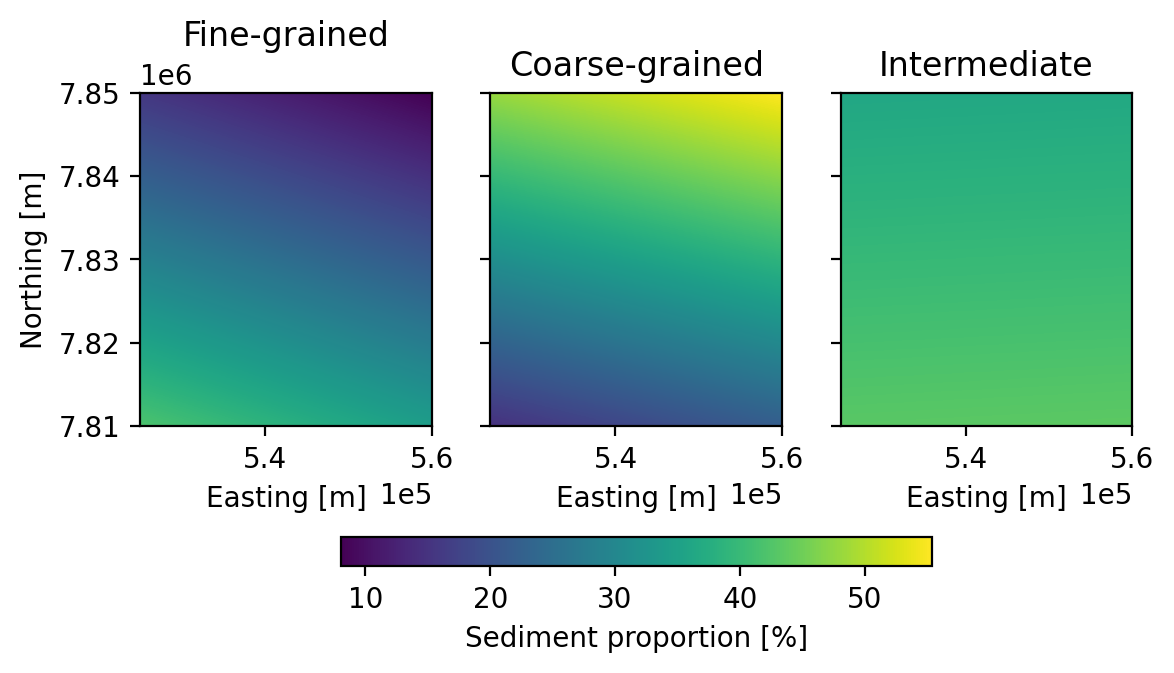

In [8]:
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('Fine-grained')
im0=ax[0].imshow(trend_clay_prop*1E2, origin='lower', cmap='viridis', extent = [xmin,xmax,ymin,ymax], vmin = trend_min*1E2, vmax = trend_max*1E2)
ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([ymin,ymax])
ax[0].set_aspect(aspectr)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[0].set_xlabel('Easting [m]')
ax[0].set_ylabel('Northing [m]')
# fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Coarse-grained')
im1=ax[1].imshow(trend_sand_prop*1E2, origin='lower', cmap='viridis', extent = [xmin,xmax,ymin,ymax], vmin = trend_min*1E2, vmax = trend_max*1E2)
ax[1].set_xlim([xmin,xmax])
ax[1].set_ylim([ymin,ymax])
ax[1].set_aspect(aspectr)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[1].set_xlabel('Easting [m]')
# ax[1].set_ylabel('Northing [m]')
# fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate')
im2=ax[2].imshow(trend_inte_prop*1E2, origin='lower', cmap='viridis', extent = [xmin,xmax,ymin,ymax], vmin = trend_min*1E2, vmax = trend_max*1E2)
ax[2].set_xlim([xmin,xmax])
ax[2].set_ylim([ymin,ymax])
ax[2].set_aspect(aspectr)
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[2].set_xlabel('Easting [m]')
# ax[2].set_ylabel('Northing [m]')
# fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

#fig.suptitle('Spatial distribution of sediment proportions')
fig.colorbar(im0,ax=ax, orientation='horizontal', fraction=.04,label='Sediment proportion [%]') #images[0], 
plt.show()

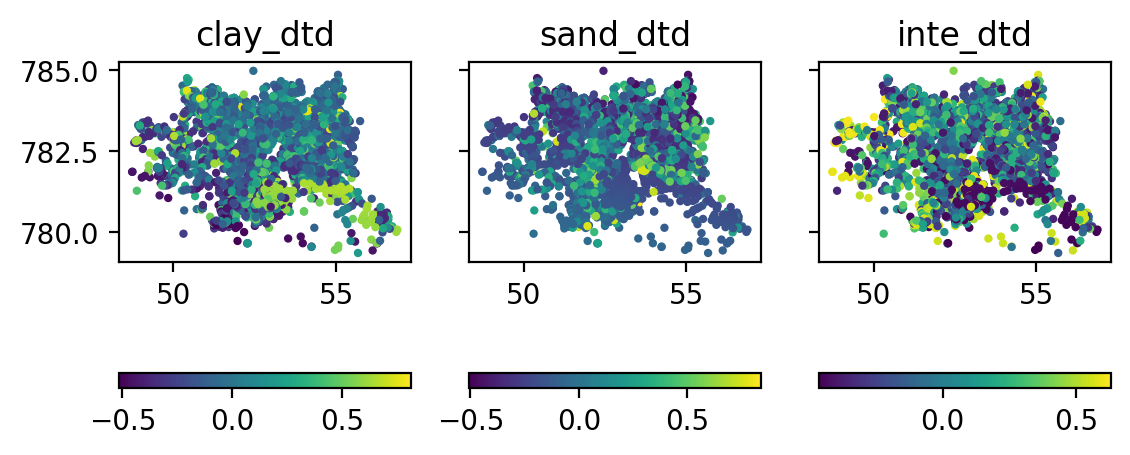

In [9]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('clay_dtd')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['clay_dtd'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('sand_dtd')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['sand_dtd'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('inte_dtd')
im2=ax[2].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['inte_dtd'].values,
                  cmap='viridis',s=s)
ax[2].set_aspect(1)
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()

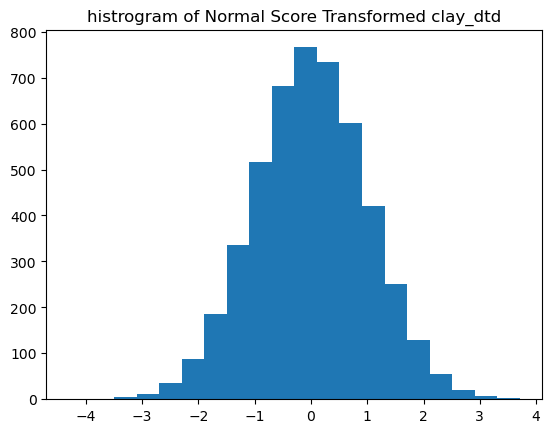

In [10]:
# NORMAL SCORE TRANSFORM
add_nst_cols(df_2D_prop,'clay_dtd',plot=True)
add_nst_cols(df_2D_prop,'sand_dtd')
add_nst_cols(df_2D_prop,'inte_dtd')

In [11]:
df_2D_prop

Unnamed: 0        RN     Easting     Northing  prop_clay  prop_sand  \
0              0     20917  526047.920  7816871.202   0.711712   0.288288   
1              1     20921  528027.083  7842476.233   0.509810   0.362818   
2              2     20922  524216.073  7820972.989   0.100281   0.814433   
3              3     20923  527924.188  7820920.088   0.518530   0.397934   
4              4     20925  523511.176  7817625.662   0.118750   0.881250   
...          ...       ...         ...          ...        ...        ...   
4838        4838  12100517  549841.859  7815890.070   0.190000   0.700000   
4839        4839  12100518  541963.563  7818005.436   0.308108   0.513514   
4840        4840  12100519  542105.282  7819134.048   0.228571   0.771429   
4841        4841  12100520  540754.172  7819932.169   0.250000   0.486364   
4842        4842  12100521  544964.047  7815652.000   0.250000   0.750000   

      prop_inte     theta       phi  clay_dtd  ...  inte_dtd  tv_clay_dtd  \
0      0.000000  1.570796  0.566788  0.338389  ... -0.420522    -0.516294   
1      0.127372  1.205857  0.700771  0.310399  ... -0.248538    -0.500058   
2      0.085286  1.274440  1.233321 -0.249924  ... -0.327897    -0.497451   
3      0.083536  1.277587  0.719413  0.176158  ... -0.330072    -0.496307   
4      0.000000  1.570796  1.218982 -0.255175  ... -0.418975    -0.493765   
...         ...       ...       ...       ...  ...       ...          ...   
4838   0.110000  1.232731  1.090500 -0.137311  ... -0.314371     0.769792   
4839   0.178378  1.134761  0.911738 -0.022582  ... -0.241586     0.774715   
4840   0.000000  1.570796  1.072316 -0.094333  ... -0.418003     0.774972   
4841   0.263636  1.031590  0.948784 -0.070601  ... -0.152849     0.775619   
4842   0.000000  1.570796  1.047198 -0.089652  ... -0.424350     0.813813   

      tns_clay_dtd  nst_clay_dtd  tv_sand_dtd  tns_sand_dtd  nst_sand_dtd  \
0        -3.710949      1.126479    -0.506930     -3.710949      0.347981   
1        -3.422952      1.057882    -0.503488     -3.422952      0.017599   
2        -3.281540     -0.974609    -0.499685     -3.281540      1.911370   
3        -3.185431      0.727599    -0.499571     -3.185431      0.533568   
4        -3.111983     -1.014499    -0.499571     -3.111983      2.483537   
...            ...           ...          ...           ...           ...   
4838      3.111983     -0.354036     0.765532      3.111983      1.351475   
4839      3.185431      0.117762     0.783369      3.185431      0.784075   
4840      3.281540     -0.173216     0.826513      3.281540      1.603534   
4841      3.422952     -0.066817     0.828782      3.422952      0.694278   
4842      3.710949     -0.155903     0.838410      3.710949      1.614869   

      tv_inte_dtd  tns_inte_dtd  nst_inte_dtd  
0       -0.461537     -3.710949     -1.687682  
1       -0.460719     -3.422952     -0.636790  
2       -0.459317     -3.281540     -0.929017  
3       -0.459000     -3.185431     -0.938622  
4       -0.456966     -3.111983     -1.679143  
...           ...           ...           ...  
4838     0.623622      3.111983     -0.864033  
4839     0.626276      3.185431     -0.608516  
4840     0.628317      3.281540     -1.652205  
4841     0.628317      3.422952     -0.316258  
4842     0.628317      3.710949     -1.727718  

[4843 rows x 21 columns]

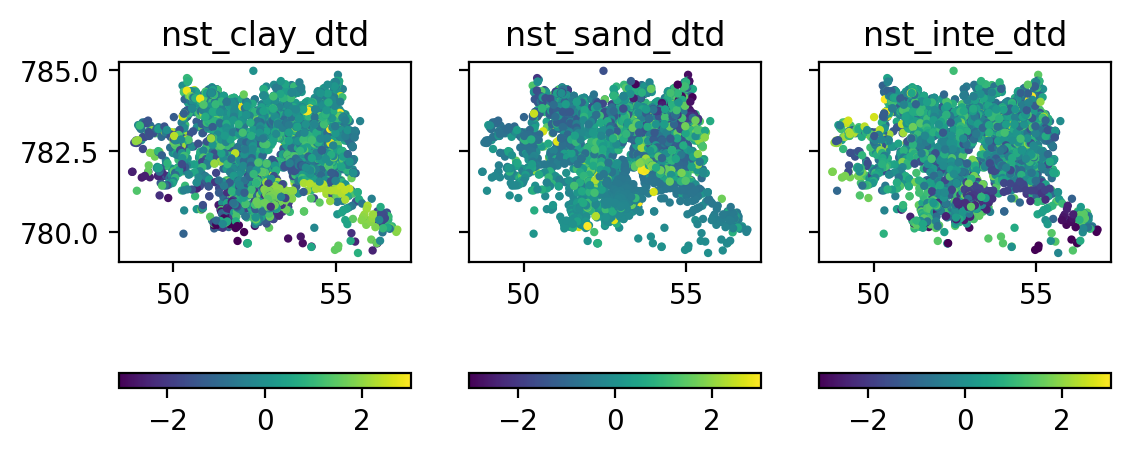

In [12]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('nst_clay_dtd')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_clay_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('nst_sand_dtd')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_sand_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('nst_inte_dtd')
im2=ax[2].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_inte_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[2].set_aspect(1)
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()

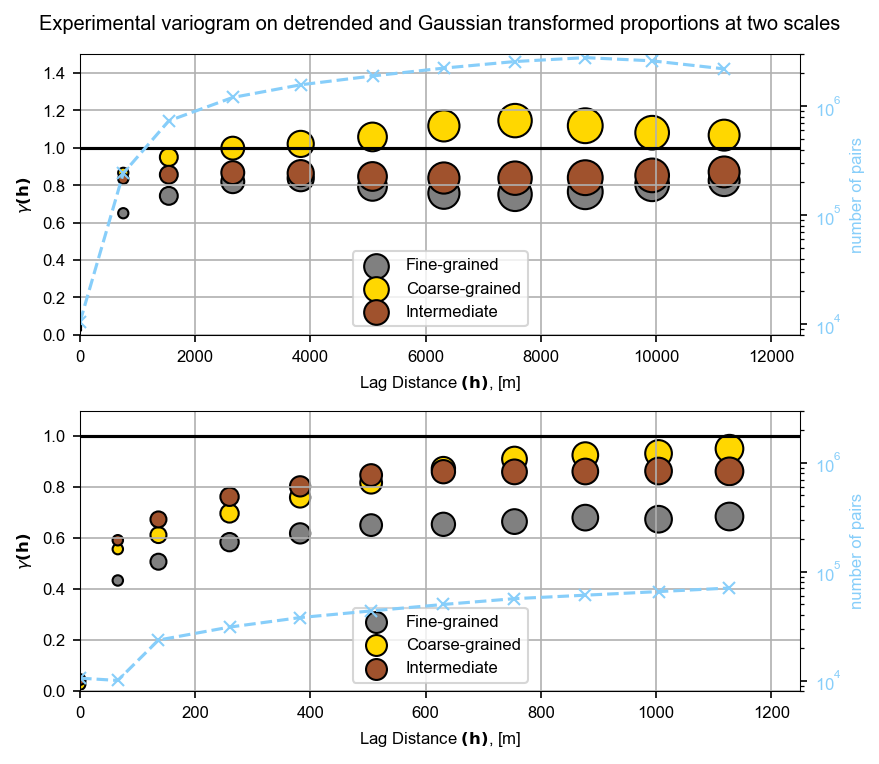

In [13]:
figsize = (15/2.54,13/2.54) # figure size in inches
fontsize = 8

plt.rc("axes", linewidth=0.5) # so lines on edges of plots aren't too thick
plt.matplotlib.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'}) # so that Arial is used
plt.rcParams.update({'font.size': fontsize})    # size 10 font


lag_nb = 10
dmax = ((xmax-xmin)+(ymax-ymin))/6
lag_width = dmax/lag_nb

#%% ISOTROPIC EXPERIMENTAL VARIOGRAM
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 90                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = 0           # directions in azimuth to consider

# Arrays to store the results
lag_clay, gamma_clay, npp_clay = geostats.gamv(df_2D_prop,'Easting','Northing','nst_clay_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat,atol,bandh,isill)
lag_sand, gamma_sand, npp_sand = geostats.gamv(df_2D_prop,'Easting','Northing','nst_sand_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat,atol,bandh,isill)
lag_inte, gamma_inte, npp_inte = geostats.gamv(df_2D_prop,'Easting','Northing','nst_inte_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat,atol,bandh,isill)

# shorter scale semi-vario
lag_nb = 10
dmax = ((xmax-xmin)+(ymax-ymin))/60
lag2width = dmax/lag_nb

#%% ISOTROPIC EXPERIMENTAL VARIOGRAM
tmin = -9999.; tmax = 9999.                             # no trimming 
lag2dist = lag2width; lag2tol = lag2dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 90                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = 0           # directions in azimuth to consider

# Arrays to store the results
lag2clay, gamma2clay, npp2clay = geostats.gamv(df_2D_prop,'Easting','Northing','nst_clay_dtd',tmin,tmax,lag2dist,lag2tol,nlag,azi_mat,atol,bandh,isill)
lag2sand, gamma2sand, npp2sand = geostats.gamv(df_2D_prop,'Easting','Northing','nst_sand_dtd',tmin,tmax,lag2dist,lag2tol,nlag,azi_mat,atol,bandh,isill)
lag2inte, gamma2inte, npp2inte = geostats.gamv(df_2D_prop,'Easting','Northing','nst_inte_dtd',tmin,tmax,lag2dist,lag2tol,nlag,azi_mat,atol,bandh,isill)

fig, ax = plt.subplots(2,1,dpi=150,figsize=figsize)
ax[0].scatter(lag_clay[:-1],gamma_clay[:-1],edgecolor='black', color = 'grey',label = 'Fine-grained', marker='o', s = npp_clay[:-1]/1E4)
ax[0].scatter(lag_sand[:-1],gamma_sand[:-1],edgecolor='black', color = 'gold',label = 'Coarse-grained', marker='o', s = npp_sand[:-1]/1E4)
ax[0].scatter(lag_inte[:-1],gamma_inte[:-1],edgecolor='black', color = 'sienna',label = 'Intermediate', marker='o', s = npp_inte[:-1]/1E4)
ax[0].plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
ax[0].set_xlabel(r'Lag Distance $\bf(h)$, [m]')
ax[0].set_ylabel(r'$\gamma \bf(h)$')
# ax[0].set_title('Large scale experimental variogram on detrended\nand Gaussian transformed proportions')
ax[0].set_xlim([0,lag_dist*nlag])
ax[0].set_ylim([0,1.5])
ax[0].legend(loc='lower center')
ax[0].grid(True)

ax2 = ax[0].twinx()  # instantiate a second Axes that shares the same x-axis

ax2.set_ylabel('number of pairs',color = 'lightskyblue')  # we already handled the x-label with ax1
ax2.plot(lag_clay[:-1],npp_clay[:-1], '--x',color = 'lightskyblue')
ax2.tick_params(axis='y',labelcolor = 'lightskyblue')
ax2.set_ylim([8E3,3E6])
ax2.set_yscale('log')

ax[1].scatter(lag2clay[:-1],gamma2clay[:-1],edgecolor='black', color = 'grey',label = 'Fine-grained', marker='o', s = npp2clay[:-1]/4E2)
ax[1].scatter(lag2sand[:-1],gamma2sand[:-1],edgecolor='black', color = 'gold',label = 'Coarse-grained', marker='o', s = npp2sand[:-1]/4E2)
ax[1].scatter(lag2inte[:-1],gamma2inte[:-1],edgecolor='black', color = 'sienna',label = 'Intermediate', marker='o', s = npp2inte[:-1]/4E2)
ax[1].plot([0,lag2dist*nlag],[1.0,1.0],color = 'black')
ax[1].set_xlabel(r'Lag Distance $\bf(h)$, [m]')
ax[1].set_ylabel(r'$\gamma \bf(h)$')
# ax[1].set_title('Small scale experimental variogram on detrended\nand Gaussian transformed proportions')
ax[1].set_xlim([0,lag2dist*nlag])
ax[1].set_ylim([0,1.1])
ax[1].legend(loc='lower center')
ax[1].grid(True)

ax3 = ax[1].twinx()  # instantiate a second Axes that shares the same x-axis

ax3.set_ylabel('number of pairs',color = 'lightskyblue')  # we already handled the x-label with ax1
ax3.plot(lag2clay[:-1],npp2clay[:-1], '--x',color ='lightskyblue')
ax3.tick_params(axis='y',labelcolor = 'lightskyblue')
ax3.set_ylim([8E3,3E6])
ax3.set_yscale('log')

fig.suptitle('Experimental variogram on detrended and Gaussian transformed proportions at two scales')

fig.tight_layout() 
plt.show()

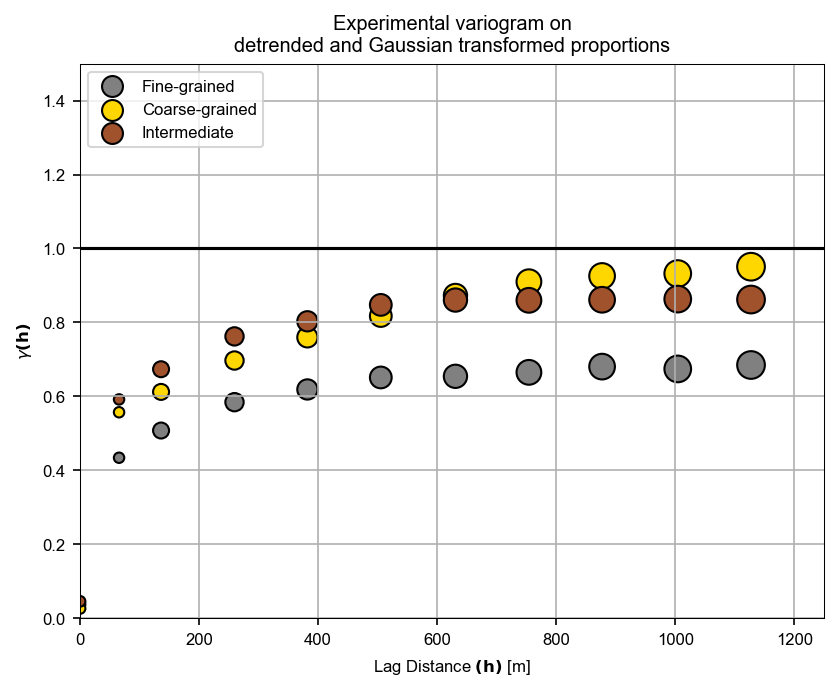

In [14]:
plt.figure(dpi=150)
plt.scatter(lag2clay[:-1],gamma2clay[:-1],edgecolor='black', color = 'grey',label = 'Fine-grained', marker='o', s = npp2clay[:-1]/4E2)
plt.scatter(lag2sand[:-1],gamma2sand[:-1],edgecolor='black', color = 'gold',label = 'Coarse-grained', marker='o', s = npp2sand[:-1]/4E2)
plt.scatter(lag2inte[:-1],gamma2inte[:-1],edgecolor='black', color = 'sienna',label = 'Intermediate', marker='o', s = npp2inte[:-1]/4E2)
plt.plot([0,lag2dist*nlag],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$ [m]')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Experimental variogram on\ndetrended and Gaussian transformed proportions')
plt.xlim([0,lag2dist*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [15]:
np.savez(output_fn,
         xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, trend_min = trend_min*1E2, trend_max = trend_max*1E2,
         trend_clay_pct = trend_clay_prop*1E2, trend_sand_pct = trend_sand_prop*1E2, trend_inte_pct = trend_inte_prop*1E2,
         lag_clay = lag_clay, gamma_clay = gamma_clay, npp_clay = npp_clay,
         lag_sand = lag_sand, gamma_sand = gamma_sand, npp_sand = npp_sand,
         lag_inte = lag_inte, gamma_inte = gamma_inte, npp_inte = npp_inte,
         lag2clay = lag2clay, gamma2clay = gamma2clay, npp2clay = npp2clay,
         lag2sand = lag2sand, gamma2sand = gamma2sand, npp2sand = npp2sand,
         lag2inte = lag2inte, gamma2inte = gamma2inte, npp2inte = npp2inte)